In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2
import sample_data

np.random.seed(0)
N_train = 50000; N_test = 5000
N = N_train + N_test
train = np.arange(N_train); test = np.arange(N_test) + N_train
n_min = 250; n_max = 250

X, Y = sample_data.periodic(N, n_min, n_max, t_max=2*np.pi, even=True,
                            A_shape=5., noise_sigma=2e-9, w_min=0.1,
                            w_max=1.)
X = X[:, :, 1:2]
print(X.shape, Y.shape)

Using TensorFlow backend.


(55000, 250, 1) (55000, 4)


[[ 0.59393215  1.52030607  4.94587978  1.31535658]
 [ 0.74367043  0.64430948  4.01291697  0.25835982]
 [ 0.64248704  1.30677354  0.15818252  0.45979868]
 [ 0.59039486  1.33445051  4.16907245  1.0294514 ]
 [ 0.48128932  0.73593862  1.57674363 -0.88478997]
 [ 0.6813047   0.7070844   3.5807295   0.61928019]]


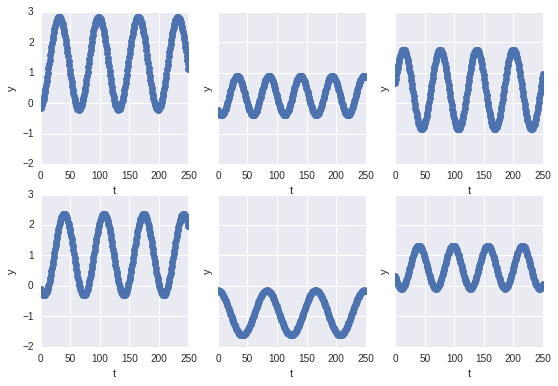

In [4]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(6):
#    i = np.where(y == j)[0][0]
    i = j
    ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[i], 'o')
#    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
    ax.ravel()[j].set(xlabel="t", ylabel="y")
print(Y[0:6, :])

In [3]:
from keras.callbacks import Callback
from IPython.core.display import clear_output

class ClearOutput(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)

In [ ]:
import os
import tensorflow as tf
from keras import backend as K
from keras.layers import (Input, Dense, TimeDistributed, Activation, LSTM,
                          Dropout, merge, Reshape, Flatten, RepeatVector)
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ProgbarLogger, TensorBoard
from keras.utils.visualize_util import model_to_dot
from IPython.display import clear_output, SVG, display

def even_lstm_sine_wave(lstm_size, num_layers, drop_frac, lr):
    gpu_opts = tf.ConfigProto(gpu_options=tf.GPUOptions(
            per_process_gpu_memory_fraction=gpu_frac))
    sess = tf.Session(config=gpu_opts)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''
#    sess = tf.Session()

    K.set_session(sess)
    run = "lstm_{:03d}_x{}_{:1.0e}_drop{}".format(lstm_size, num_layers, lr, drop_frac).replace('e-', 'm').replace('.', '')
    print(run)
    model = Sequential()
    model.add(LSTM(lstm_size, input_shape=(n_max, X.shape[-1]),
                   return_sequences=(num_layers > 1)))
    for i in range(1, num_layers):
        model.add(Dropout(drop_frac))
        model.add(LSTM(lstm_size, return_sequences=True))
    adam = Adam(lr=lr)
    model.compile(optimizer=adam, loss='mse', metrics=[])

#    model_dot = model_to_dot(model).create(prog='dot', format='svg')
#    print('{} MB'.format(model.count_params() * np.dtype('float32').itemsize / 1e6))
#    print(model.summary())
#    display(SVG(model_dot))

    log_dir = os.path.expanduser('~/Dropbox/Documents/timeflow/keras_logs/period/{}'.format(run))
    !rm -rf $log_dir
    history = model.fit(Y[train], X[train], 
                         nb_epoch=nb_epoch, batch_size=batch_size, validation_split=0.2,
                         callbacks=[ProgbarLogger(), TensorBoard(log_dir=log_dir, write_graph=False)])
    model.save_weights(os.path.join(log_dir, 'weights.h5'), overwrite=True)
    return (run, history, model)

In [ ]:
from itertools import product
from joblib import Parallel, delayed

batch_size = 500
nb_epoch = 50
gpu_frac = 1.0
            
#Parallel(n_jobs=12)(delayed(even_lstm_period_estimator)(128, num_layers, drop_frac, 2e-3)
#                   for num_layers, drop_frac in product([1, 2, 3], [0.0, 0.25, 0.5]))
for num_layers in [1, 2, 3]:
    for drop_frac in [0.0, 0.25, 0.5]:
        run, history, model = even_lstm_period_estimator(128, num_layers, 
                                                         drop_frac, 2e-3)
        clear_output()

In [ ]:
%%time
pred_keras = model.predict(X[test]).ravel()

In [ ]:
%%time
from gatspy.periodic import LombScargle, LombScargleFast

pred_gatspy = np.zeros(N_test)
for i in range(N_test):
    opt_args = {'period_range': (0.1, 0.9 * (X[test[i]][-1, 0] - X[test[i]][0, 0])), 'quiet': True}
    model_gatspy = LombScargle(fit_period=True, optimizer_kwds=opt_args)#, silence_warnings=True)
    pred_gatspy[i] = 1. / model_gatspy.fit(X[test[i]][:, 0], X[test[i]][:, 1]).best_period

In [ ]:
model_gatspy._best_params(2 * np.pi / model_gatspy.best_period)

In [ ]:
model_gatspy._

In [ ]:
sns.jointplot(pred_keras - testY, pred_gatspy - testY)

In [ ]:
print(np.median((pred_keras - testY) ** 2))
print(np.median((pred_gatspy - testY) ** 2))